In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# device logic
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# transforms: add normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # mean=0.5, std=0.5 for 1-channel
])

train_ds = datasets.FashionMNIST("data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST("data", train=False, download=True, transform=transform)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=256)
print(len(train_ds), "train samples,", len(test_ds), "test samples")


Using device: mps
60000 train samples, 10000 test samples


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B,1,28,28)→(B,32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # →(B,32,14,14)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # →(B,64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # →(B,64,7,7)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # →(B,64*7*7)
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)                            # logits
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam often works well for CNNs

In [4]:
num_epochs = 5
train_accs, test_accs = [], []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*X.size(0)
        correct += (logits.argmax(1)==y).sum().item()

    train_acc = correct / len(train_ds)
    train_accs.append(train_acc)

    # eval
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)
            correct += (model(X).argmax(1)==y).sum().item()
    test_acc = correct / len(test_ds)
    test_accs.append(test_acc)

    print(f"Epoch {epoch}: train acc {train_acc:.2%} | test acc {test_acc:.2%}")


Epoch 1: train acc 80.31% | test acc 87.18%
Epoch 2: train acc 87.50% | test acc 89.19%
Epoch 3: train acc 89.26% | test acc 89.92%
Epoch 4: train acc 90.29% | test acc 91.29%
Epoch 5: train acc 91.16% | test acc 91.43%


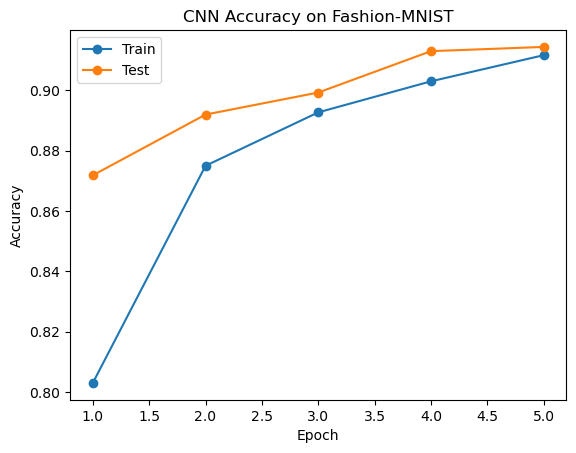

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(1,num_epochs+1), train_accs, marker='o', label="Train")
plt.plot(range(1,num_epochs+1), test_accs,  marker='o', label="Test")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("CNN Accuracy on Fashion-MNIST")
plt.legend(); plt.show()

### Reflection

* **Convs vs. FCs:** Convolutional layers learn local patterns (edges/textures), giving huge accuracy lifts on images.
* **Adam optimizer:** Adaptive learning rates help train deeper nets faster than vanilla SGD.
* **Dropout:** Prevents overfitting by randomly silencing neurons during training.
* **Normalization:** Centering and scaling pixel values accelerates convergence.


In [11]:
import os

save_path = os.path.expanduser("/Users/apple/LLM-60-Day-Sprint/outputs/cnn_model.pt")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Saved CNN weights → {save_path}")

Saved CNN weights → /Users/apple/LLM-60-Day-Sprint/outputs/cnn_model.pt
